In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Traffic Flow 
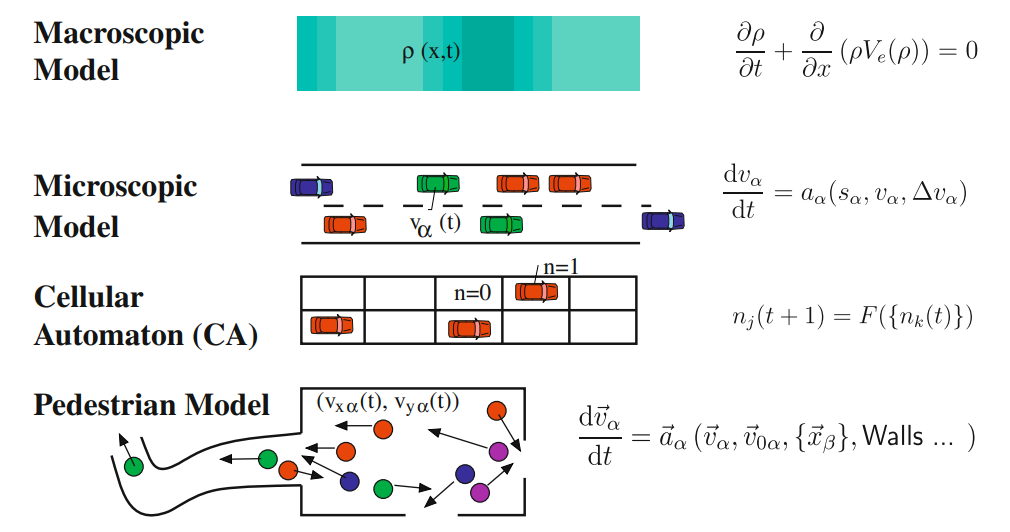